In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from plotting_utilities import *
import logging
%matplotlib inline

# Error vs Iterations 

In [11]:
seed_size = 100
batch_sizes = [2, 4, 8]
# test_funcs = ["branin","egg", "hartmann"]
test_funcs = ["hartmann"]
metrics = ["IR", "L2"]
save_file = True
log_results = True

plot_choice = {
        "seq_results": 1, 
        "random_results": 0,
        "random1_results": 0,
        "kb_results": 0,
        "cl_mean_results": 0, 
        "cl_min_results": 1,
        "cl_max_results": 0,
        "gpyopt_localp": 0,
        "gpyopt_ard_localp": 0,
        "gpyopt_sequential": 0,
        }

label_lookup = {
        "seq_results": "Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "Kriging Believer",
        "cl_mean_results": "Constant Liar (Mean)", 
        "cl_min_results": "Constant Liar (Min)",
        "cl_max_results": "Constant Liar (Max)",
        "gpyopt_localp": "Local Penalisation",
        "gpyopt_ard_localp": "Local Penalisation",
        "gpyopt_sequential": "Gpyopt Sequential"
        }

if log_results == True:
    metric_lookup = {
            "L2": "Log L2 norm between actual and guessed x*",
            "IR": "Log absolute distance between actual and guessed y*",
            }
else:
    metric_lookup = {
            "L2": "L2 norm between actual and guessed x*",
            "IR": "Absolute distance between actual and guessed y*",
            }
#estimator = np.median
estimator = "mean"

In [7]:
#####
# 1. Error against number of iterations
#####
def error_vs_iterations_v2(func = "egg", seed_size = 2, metrics = "IR", batch = False, batch_size = 2, heuristic = "kb"):
    if batch == False:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/" 
        filename = "A_results_" + metrics + ",sequential.npy"
        results = np.load(dir_name + filename)
    else:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed," + str(batch_size) + "_batch_size/"
        filename = "A_results_" + metrics + "," + heuristic + "_heuristic.npy"
        results = np.load(dir_name + filename)
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
        
    df = np_to_df(results)
    return df

if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"

def plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file):   
    # Loads, plots and saves graphs     
    for metric in metrics:
        plt.figure() # New figure
        
        for batch_size in batch_sizes:
            plt.figure() # New figure
            
            for func in test_funcs:
                plt.figure()
                try: 
                    seq_results = error_vs_iterations_v2(batch = False, metrics = metric, func = func, \
                                                         batch_size = batch_size, seed_size = seed_size)
                except Exception as e:
                    print('Error: '+ str(e))
                try:
                    random_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "random")
                except: pass
                try:
                    random1_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "random_except_1st")
                except: pass
                try:
                    kb_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                        batch_size = batch_size, seed_size = seed_size, heuristic = "kb")
                except: pass
                try:
                    cl_mean_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "cl-mean")
                except: pass
                try:
                    cl_min_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-min")
                except: pass
                try:
                    cl_max_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-max")
                except: pass
                
                try:
                    gpyopt_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "EI", "local_penalization")
                except:
                    pass
                try:
                    gpyopt_ard_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "EI", \
                                                      "local_penalization", ard = True)
                except: pass
                """
                try:
                    gpyopt_sequential = load_gpyopt_error(func, metric, 1, seed_size, "EI", "sequential")
                except:
                    pass
                """
                
                for key, value in plot_choice.items():
                    if value == 1:
                        df = eval(key)
                        if log_results == True: df['values'] = np.log(df['values'])
                        fig = sns.lineplot(x = 'iters', y = 'values', data = df, err_style = "band", \
                                           label = label_lookup[key], estimator = estimator)
                
                graph_title = str(batch_size) + "-Batch on "+ str(func) + " function (" + estimator_title + ", " + str(seed_size) + " seed)"
                fig.set(xlabel = "No. of Iterations", ylabel = metric_lookup[metric], title = graph_title)
                if log_results == True:
                    save_path = "Exp_Data/Graphs/" + graph_title + "_log_" + str(metric) + ".png"
                else:
                    save_path = "Exp_Data/Graphs/" + graph_title + "_" + str(metric) + ".png"
                fig2 = fig.get_figure()
                
                if save_file:
                    print("Saved as: " + save_path)
                    
                    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
                        os.remove(save_path)
                        
                    fig2.savefig(save_path)


In [9]:
gpyopt_sequential = load_gpyopt_error("hartmann", "IR", 1, 100, "EI", "sequential")

FileNotFoundError: [Errno 2] No such file or directory: 'Exp_Data/gpyopt/hartmann,100_seed,1_batch/EI,sequential,results_vars.pickle'

c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Saved as: Exp_Data/Graphs/2-Batch on hartmann function (mean, 100 seed)_log_IR.png
Saved as: Exp_Data/Graphs/4-Batch on hartmann function (mean, 100 seed)_log_IR.png
Saved as: Exp_Data/Graphs/8-Batch on hartmann function (mean, 100 seed)_log_IR.png
Saved as: Exp_Data/Graphs/2-Batch on hartmann function (mean, 100 seed)_log_L2.png
Saved as: Exp_Data/Graphs/4-Batch on hartmann function (mean, 100 seed)_log_L2.png
Saved as: Exp_Data/Graphs/8-Batch on hartmann function (mean, 100 seed)_log_L2.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

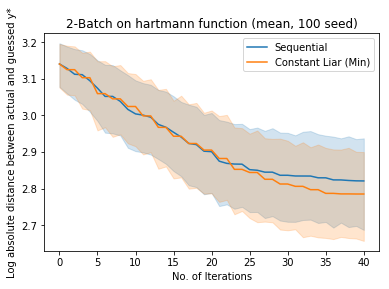

<Figure size 432x288 with 0 Axes>

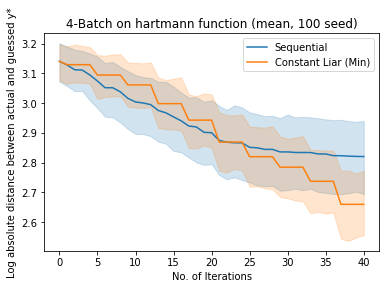

<Figure size 432x288 with 0 Axes>

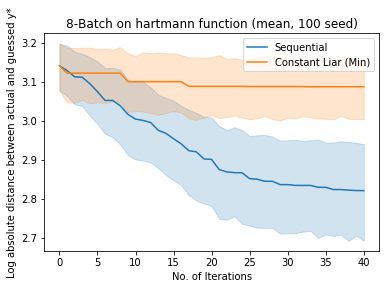

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

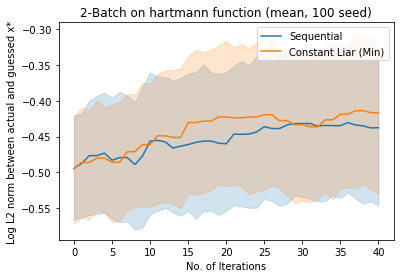

<Figure size 432x288 with 0 Axes>

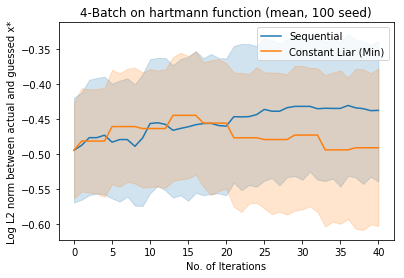

<Figure size 432x288 with 0 Axes>

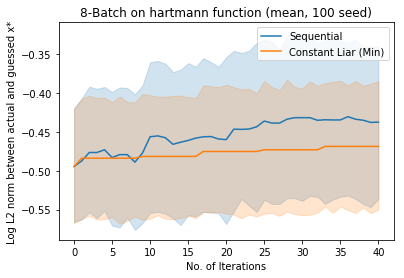

In [12]:
plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file)

# MLE vs Marginalisation of Hyperparameters

In [2]:
def error_vs_iterations_MLE(func = "egg", seed_size = 2, metrics = "IR", batch = False, batch_size = 2, heuristic = "kb"):
    if batch == False:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential,MLE/" 
        filename = "A_results_" + metrics + ",sequential.npy"
        results = np.load(dir_name + filename)
    else:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed," + str(batch_size) + "_batch_size/"
        filename = "A_results_" + metrics + "," + heuristic + "_heuristic.npy"
        results = np.load(dir_name + filename)
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
    
    df = np_to_df(results)
    return df


In [1]:
funcs = ["egg", "branin"]
save_file = True
seed_size = 50

For sequential

/home/jian/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Saved as: Exp_Data/Graphs/Hyperparameter treatments for egg function (50 seed).png
Saved as: Exp_Data/Graphs/Hyperparameter treatments for branin function (50 seed).png


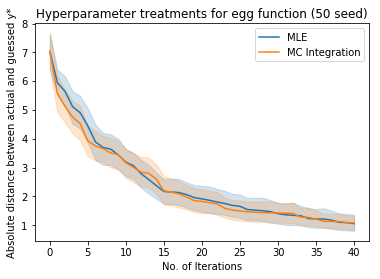

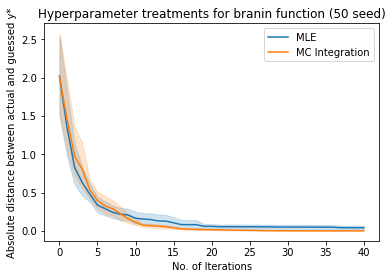

In [4]:
for func in funcs:
    plt.figure()
    
    seq_results_mle = error_vs_iterations_MLE(batch = False, metrics = "IR", func = func, \
                                                             batch_size = 1, seed_size = seed_size)
    seq_results = error_vs_iterations_v2(batch = False, metrics = "IR", func = func, \
                                                             batch_size = 1, seed_size = seed_size)
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results_mle, err_style = "band", \
                                           label = "MLE", estimator = "mean")
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results, err_style = "band", \
                                               label = "MC Integration", estimator = "mean")
    
    graph_title = "Hyperparameter treatments for " + str(func) + " function (" + str(seed_size) + " seed)"
    fig.set(xlabel = "No. of Iterations", ylabel = "Absolute distance between actual and guessed y*", title = graph_title)
    save_path = "Exp_Data/Graphs/" + graph_title + ".png"
    fig2 = fig.get_figure()

    if save_file:
        print("Saved as: " + save_path)

        if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
            os.remove(save_path)

        fig2.savefig(save_path)
    

For batch

Exp_Data/egg,50_seed,2_batch_size/A_results_IR,kb_heuristic.npy
Saved as: Exp_Data/Graphs/Hyperparameter treatments for egg function (50 seed).png
Exp_Data/branin,50_seed,2_batch_size/A_results_IR,kb_heuristic.npy
Saved as: Exp_Data/Graphs/Hyperparameter treatments for branin function (50 seed).png


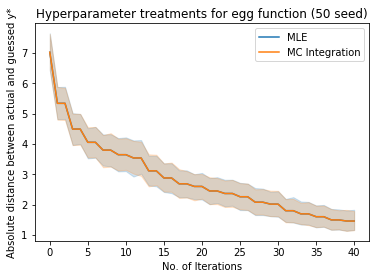

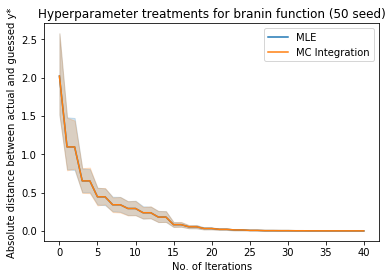

In [61]:
for func in funcs:
    plt.figure()
    
    seq_results_mle = error_vs_iterations_MLE(batch = True, metrics = "IR", func = func, \
                                                             batch_size = 2, seed_size = seed_size)
    seq_results = error_vs_iterations_v2(batch = True, metrics = "IR", func = func, \
                                                             batch_size = 2, seed_size = seed_size)
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results_mle, err_style = "band", \
                                           label = "MLE", estimator = "mean")
    fig = sns.lineplot(x = 'iters', y = 'values', data = seq_results, err_style = "band", \
                                               label = "MC Integration", estimator = "mean")
    
    graph_title = "Hyperparameter treatments for " + str(func) + " function (" + str(seed_size) + " seed)"
    fig.set(xlabel = "No. of Iterations", ylabel = "Absolute distance between actual and guessed y*", title = graph_title)
    save_path = "Exp_Data/Graphs/" + graph_title + ".png"
    fig2 = fig.get_figure()

    if save_file:
        print("Saved as: " + save_path)

        if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
            os.remove(save_path)

        fig2.savefig(save_path)
    

# Boston Hyperparameter Tuning

Code for gpyopt results

In [17]:
def load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type):
    dir_name = "Exp_Data/boston_" + ml_algo + "/gpyopt/" + str(batch_size) + '_batch/'
    file_name = dir_name + acq_func + ',' + eval_type + ',results_vars.pickle'
    
    with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
        pickle_dict = pickle.load(f)
        X = pickle_dict["X"]
        min_y = pickle_dict["min_y"]
        #eval_record = pickle_dict["eval_record"]
        x_hist = pickle_dict["x_hist_dict"]
        y_hist = pickle_dict["y_hist_dict"]
    
    return X, min_y, x_hist, y_hist
    #return X, min_y, eval_record

# acq_func: "EI" / "EI_MCMC" / "MPI_MCMC" /  "LCB" / "LCB_MCMC"
# evaluator_type: sequential / random  (1st random in Jian's deifnition) / local_penalization / thompson_sampling 

def load_gpyopt_error_boston(ml_algo = "gbr", batch_size = 2, acq_func = "EI", eval_type = "local_penalization", 
                             metric = "y_hist"):
    """
    Returns either y_hist or y_opt 
    """
    
    x_opt, y_opt, x_hist, y_hist = load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type)
    #x_opt, y_opt, eval_record = load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type)
    
    if metric.lower() == "y_hist":
        y = y_hist
    elif metric.lower() == "y_optimum":
        y = y_opt
    else:
        print("Metric not available.")
    
    # Currently only analysing error
    init = np.reshape(y[0], (1,-1))
    error_array = np.array(init)
    for seed in y:
        if y[seed].shape == y[0].shape: # check whether gpyopt result is correct, as bugs frequently occur
            results = np.reshape(y[seed], (1,-1))
            error_array = np.vstack((error_array, results))
            
        else:
            print(str(seed) + " has errors.")
        
    results = error_array[1:] # remove first one which is duplicate
    
    if batch_size > 1:
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
    
    results = min_y_hist(results) # Choose minimum until this iter
    
    df = np_to_df(results)
    return df

Code for Batch FITBO

In [5]:
def error_vs_iterations_boston(ml_algo = "gbr", seed_size = 2, batch_size = 2, heuristic = "kb", metrics = "y_hist"):
    dir_name = "Exp_Data/boston_" + ml_algo + "/fitbo/batch_" + str(batch_size) + "/"
    # TODO: fix filename for batch = 1
    filename = "batch_" + str(batch_size) + ",seed_" + str(seed_size) + "," + heuristic + "," + metrics + ".npy"
    results = np.load(dir_name + filename)
    
    if metrics == "y_hist": # if plotting y_hist, choose minimum sample up till this point
        results = min_y_hist(results)
    
    if batch_size > 1:
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
        results = results[:,(batch_size-1):] # Do not duplicate initial error
    
    df = np_to_df(results)
    return df

gbr EI
dict_keys(['X', 'min_y', 'x_hist_dict', 'y_hist_dict'])
dnn EI
dict_keys(['X', 'min_y', 'x_hist_dict', 'y_hist_dict'])
9 has errors.
24 has errors.
gbr EI
dict_keys(['X', 'min_y', 'x_hist_dict', 'y_hist_dict'])
dnn EI
dict_keys(['X', 'min_y', 'x_hist_dict', 'y_hist_dict'])
gbr EI
dict_keys(['X', 'min_y', 'x_hist_dict', 'y_hist_dict'])
dnn EI
dict_keys(['X', 'min_y', 'x_hist_dict', 'y_hist_dict'])


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

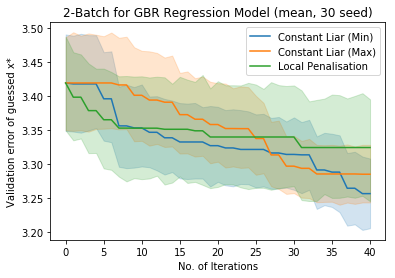

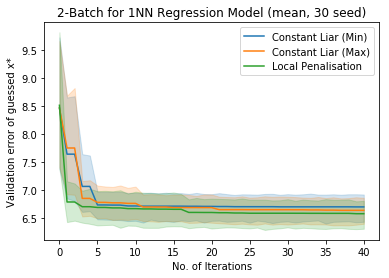

<Figure size 432x288 with 0 Axes>

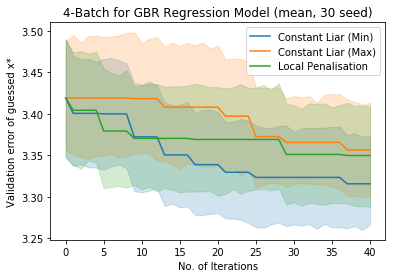

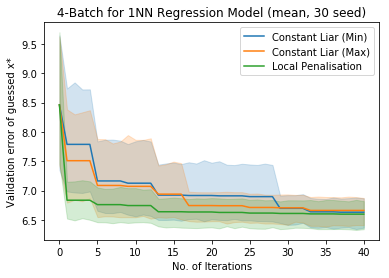

<Figure size 432x288 with 0 Axes>

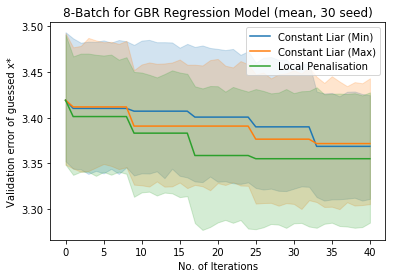

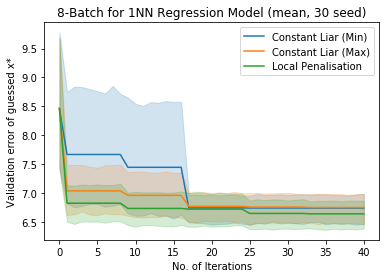

In [16]:
seed_size = 30
batch_sizes = [2,4, 8]
test_funcs = ["gbr", "dnn"]
# metrics = ["y_hist", "y_optimum"]
metrics = ["Y_optimum"]
save_file = False

plot_choice = {
        "seq_results": 0, 
        "kb_results": 0,
        "cl_mean_results": 0, 
        "cl_min_results": 1,
        "cl_max_results": 1,
        "gpyopt_localp": 1,
        "gpyopt_sequential": 0,
        }

label_lookup = {
        "seq_results": "Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "Kriging Believer",
        "cl_mean_results": "Constant Liar (Mean)", 
        "cl_min_results": "Constant Liar (Min)",
        "cl_max_results": "Constant Liar (Max)",
        "gpyopt_localp": "Local Penalisation",
        "gpyopt_sequential": "Gpyopt Sequential"
        }

metric_lookup = {
        "Y_hist": "Validation error of best sampled point",
        "Y_optimum": "Validation error of guessed x*",
        }

estimator = "mean"
#estimator = np.median

if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"
    
def plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file):   
    # Loads, plots and saves graphs     
    for metric in metrics:
        plt.figure() # New figure
        
        for batch_size in batch_sizes:
            plt.figure() # New figure
            
            for func in test_funcs:
                plt.figure()
                try: 
                    seq_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size)
                    
                except: pass
                try:
                    kb_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "kb")
                except: pass
                try:
                    cl_mean_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "cl-mean")
                except: pass
                try:
                    cl_min_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "cl-min")
                except Exception as e:
                    print('Error: '+ str(e))
                try:
                    cl_max_results = error_vs_iterations_boston(metrics = metric, ml_algo = func, \
                                                         batch_size = batch_size, seed_size = seed_size, heuristic = "cl-max")
                except: pass

                try:
                    gpyopt_localp = load_gpyopt_error_boston(ml_algo = func, metric = metric, batch_size = batch_size, \
                                                             acq_func = "EI", eval_type = "local_penalization")

                except:
                    pass

                for key, value in plot_choice.items():
                    if value == 1:
                        fig = sns.lineplot(x = 'iters', y = 'values', data = eval(key), err_style = "band", \
                                           label = label_lookup[key], estimator = estimator)
                if func == "dnn": func = "1NN"
                graph_title = str(batch_size) + "-Batch for "+ func.upper() + " Regression Model (" + estimator_title + ", " + str(seed_size) + " seed)"
                fig.set(xlabel = "No. of Iterations", ylabel = metric_lookup[metric], title = graph_title)
                save_path = "Exp_Data/Graphs/" + graph_title + "_" + str(metric) + ".png"
                fig2 = fig.get_figure()
                
                if save_file:
                    print("Saved as: " + save_path)
                    
                    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
                        os.remove(save_path)
                        
                    fig2.savefig(save_path)

plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file)
